## Multi node type Graph

In [1]:
#Dummy raw data

df = spark.createDataFrame(
    schema=("_fruit",),
    data=[
        ("ORANGE",),
        ("WATERMELON",),
        ("LEMON",),
    ]
)
df.createOrReplaceTempView("table")
display(df)

_fruit
ORANGE
WATERMELON
LEMON


### Define the Graph

In [2]:
from flypipe import node
from flypipe.datasource.spark import Spark
from flypipe.schema import Schema, Column
from flypipe.schema.types import String

import pyspark.sql.functions as F


@node(
    type="pandas_on_spark",
    dependencies=[
        Spark("table").select("_fruit").alias("df")
    ],
    output=Schema(
     Column("fruit", String(), "fruit description"),
    )
)
def rename_clean(df):
    df = df.rename(columns={'_fruit': 'fruit'})
    df['fruit'] = df['fruit'].str.lower()
    return df



@node(
    type="pandas_on_spark",
    dependencies=[
       rename_clean.select("fruit").alias("df")
    ],
    output=Schema(
        rename_clean.output.get("fruit"),
        Column("color", String(), "color of the fruit"),
    )
)
def color(df):

    replacements = {
        "orange": "orange",
        "watermelon": "red",
        "lemon": "yellow",
    }
    df['color'] = df['fruit']
    df = df.replace({'color': replacements})
    return df



@node(
    type="pandas_on_spark",
    dependencies=[
       rename_clean.select("fruit").alias("df")
    ],
    output=Schema(
        rename_clean.output.get("fruit"),
        Column("category", String(), "category of the fruit"),
    )
)
def category(df):

    replacements = {
        "orange": "citric",
        "watermelon": "sweet",
        "lemon": "citric",
    }
    
    df['category'] = df['fruit']
    df = df.replace({'category': replacements})
    return df


@node(
    type="pandas",
    dependencies=[
       color.select("fruit", "color"),
       category.select("fruit", "category")
    ],
    output=Schema(
        color.output.get("fruit"),
        color.output.get("color"),
        category.output.get("category"),
    )
)
def fruits(color, category):
    return color.merge(category, on="fruit", how="left")


The code above created a graph with 3 types of nodes

* table: `pyspark` node
* clean: `pandas_on_spark` node
* color: `pandas_on_spark` node
* category: `pandas` node

As you can see the graph bellow:

In [3]:
html_width=600
html_height=300
displayHTML(fruits.html(width=html_width, height=html_height))

When running this graph the following processes will be executed:

1. spark will query the table and select the columns specified in node `table`
2. before running node `rename_clean`, flypipe will convert the ouput *pyspark* dataframe from node `table` to a *pandas_on_spark* dataframe
3. node `rename_clean` is processed
4. nodes `color` and `category` will be processed using the output *pandas_on_spark* dataframe output by node `rename_clean`
5. once nodes `color` and `category` are processed, each dataframe is converted to `pandas` dataframe as node `fruits` is of the type *pandas*
6. node `fruits` is processed and its dataframe output is returned

Flypipe managages all these sequences and transformations for the user.

### Advantages of mixed node types pipelines

As *Flypipe* can manage different types of nodes, it allows:

* unifies different teams pipelines end-to-end (data -> feture engineering -> modelling -> inference -> ...) [^1]
* can lead to much faster results if running nodes `pandas_on_spark` as `pandas`
* same pipeline can be used within APIS to run on the fly transformations

[^1]: Different teams can use different syntaxes, i.e. `pyspark` is commnly used by data engineers, and `pandas` is commonly used by machine learning and data science teams

### Running Types

In [4]:
import pandas as pd
results = pd.DataFrame(columns=['experiment', 'running_time_ms'])

#### Default (as implemented)

```python

fruits.run(spark)

```

In [5]:
experiment = "Default (as implemented)"
result = %timeit -o fruits.run(spark)
results.loc[results.shape[0]] = [experiment, result.average]

displayHTML(fruits.html(width=html_width, height=html_height))

424 ms ± 84.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Default (as implemented) + provided `pyspark` dataframe as input

```python
fruit_table_df = spark.createDataFrame(
    pd.DataFrame(data={"_fruit": ["ORANGE", "WATERMELON", "LEMON"]})
)

fruits.run(inputs={ 
    Spark("table"): fruit_table_df 
})

```

In [6]:
experiment = "Default (as implemented) + provided `pyspark` dataframe as input"
print(experiment)
fruit_table_df = spark.createDataFrame(pd.DataFrame(data={"_fruit": ["ORANGE", "WATERMELON", "LEMON"]}))
result = %timeit -o fruits.run(inputs={ Spark("table"): fruit_table_df })
results.loc[results.shape[0]] = [experiment, result.average]

displayHTML(fruits.html(inputs={ Spark("table"): fruit_table_df }, width=html_width, height=html_height))

Default (as implemented) + provided `pyspark` dataframe as input
283 ms ± 47.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Default (as implemented) + provided `pandas` dataframe as input

```python
fruit_table_df = pd.DataFrame(data={"_fruit": ["ORANGE", "WATERMELON", "LEMON"]})

fruits.run(inputs={ 
    Spark("table"): fruit_table_df 
})

```

In [7]:
# Running pandas_on_spark nodes as pandas and with provided input
fruit_table_df = pd.DataFrame(data={"_fruit": ["ORANGE", "WATERMELON", "LEMON"]})

experiment = "Default (as implemented) + provided `pandas` dataframe as input"
print(experiment)
result = %timeit -o fruits.run(spark, inputs={ Spark("table"): fruit_table_df })
results.loc[results.shape[0]] = [experiment, result.average]

displayHTML(fruits.html(inputs={ Spark("table"): fruit_table_df }, width=html_width, height=html_height))

Default (as implemented) + provided `pandas` dataframe as input
277 ms ± 26.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### `pandas_on_spark` nodes as `pandas`

```python

fruits.run(
    spark, 
    pandas_on_spark_use_pandas=True
)

```

In [8]:
experiment = "`pandas_on_spark` nodes as `pandas`"
print(experiment)
result = %timeit -o fruits.run(spark, pandas_on_spark_use_pandas=True)
results.loc[results.shape[0]] = [experiment, result.average]

displayHTML(fruits.html(pandas_on_spark_use_pandas=True, width=html_width, height=html_height))

`pandas_on_spark` nodes as `pandas`
70.5 ms ± 10.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### `pandas_on_spark` nodes as `pandas` + provided `pyspark` dataframe as input

```python
fruit_table_df = spark.createDataFrame(
    pd.DataFrame(data={"_fruit": ["ORANGE", "WATERMELON", "LEMON"]})
)

fruits.run(
    pandas_on_spark_use_pandas=True, 
    inputs={ 
        Spark("table"): fruit_table_df 
    }
)

```

In [9]:
experiment = "`pandas_on_spark` nodes as `pandas` + provided `pyspark` dataframe as input"
print(experiment)
fruit_table_df = spark.createDataFrame(pd.DataFrame(data={"_fruit": ["ORANGE", "WATERMELON", "LEMON"]}))
result = %timeit -o fruits.run(pandas_on_spark_use_pandas=True, inputs={ Spark("table"): fruit_table_df })
results.loc[results.shape[0]] = [experiment, result.average]

displayHTML(fruits.html(inputs={ Spark("table"): fruit_table_df }, pandas_on_spark_use_pandas=True, width=html_width, height=html_height))

`pandas_on_spark` nodes as `pandas` + provided `pyspark` dataframe as input
35.3 ms ± 2.22 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### `pandas_on_spark` nodes as `pandas` + provided `pandas` dataframe as input

```python
fruit_table_df = pd.DataFrame(data={"_fruit": ["ORANGE", "WATERMELON", "LEMON"]})

fruits.run(
    pandas_on_spark_use_pandas=True, 
    inputs={ 
        Spark("table"): fruit_table_df 
    }
)

```

In [10]:
experiment = "`pandas_on_spark` nodes as `pandas` + provided `pandas` dataframe as input"
print(experiment)
fruit_table_df = pd.DataFrame(data={"_fruit": ["ORANGE", "WATERMELON", "LEMON"]})
result = %timeit -o fruits.run(pandas_on_spark_use_pandas=True, inputs={ Spark("table"): fruit_table_df })
results.loc[results.shape[0]] = [experiment, result.average]

displayHTML(fruits.html(inputs={ Spark("table"): fruit_table_df }, pandas_on_spark_use_pandas=True, width=html_width, height=html_height))

`pandas_on_spark` nodes as `pandas` + provided `pandas` dataframe as input
8.6 ms ± 1.19 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [11]:
from textwrap import wrap
results['experiment'] = results['experiment'].apply(lambda x: '\n'.join(wrap(x, 20)))
results['running_time_ms'] = results['running_time_ms'] * 1000
results['running_time_ms'] = round(results['running_time_ms'], 1)
# results = results.sort_values('running_time_ms', ascending=False)

#### Benchmark

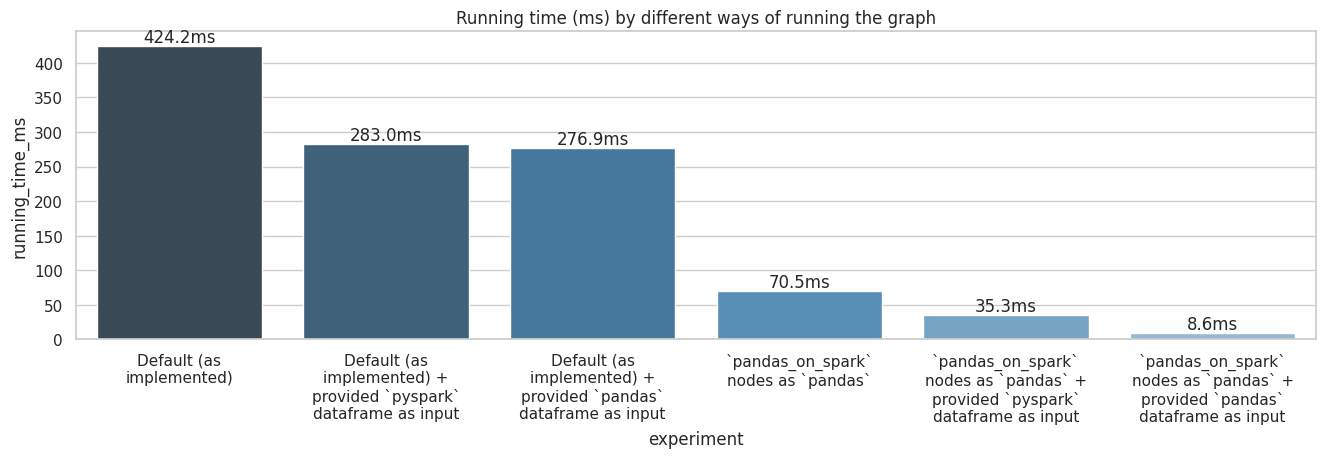

----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 54968)
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/local/lib/python3.9/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/usr/local/lib/python3.9/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/local/lib/python3.9/socketserver.py", line 747, in __init__
    self.handle()
  File "/usr/local/lib/python3.9/site-packages/pyspark/accumulators.py", line 281, in handle
    poll(accum_updates)
  File "/usr/local/lib/python3.9/site-packages/pyspark/accumulators.py", line 253, in poll
    if func():
  File "/usr/local/lib/python3.9/site-packages/pyspark/accumulators.py", line 257, in accum_updates
    num_updates = read_int(sel

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
fig, ax = plt.subplots(figsize=(16, 4))
pal = sns.color_palette("Blues_d", len(results))
barchart = (
    sns.barplot(x=results['experiment'], 
                y=results['running_time_ms'], 
                palette=np.array(pal[::-1]),
                ax=ax)
                .set(title='Running time (ms) by different ways of running the graph')
)
_ = ax.bar_label(ax.containers[0], fmt='%.1fms')

### Choosing the right run type

```{note}

These are only advices and it will dependend on the graph you are running and its purpose (if development, production big amount of data, production speed and small amount of data, etc).

```

**Default (as implemented)**

* Running pipelines
* Big volume of data

**Default (as implemented) + provided `pyspark` dataframe as input**

* Debugging failed pipelines
* Last check before finishing development

**Default (as implemented) + provided `pandas` dataframe as input**

* Developing pipelines
* Extract a small set of data into a Pandas dataframe will be faster to run the pipeline multiple times during development

**pandas_on_spark nodes as pandas**

* Pipelines with small amount of data

**pandas_on_spark nodes as pandas + provided pyspark dataframe as input**

* Pipelines with small amount of data

**pandas_on_spark nodes as pandas + provided pandas dataframe as input**

* When speed is important
* Small amount of data
* On demand feature generation
* Within APIs (running pipeline with data sent in requests)
* Unit tests (will avoid use of a spark session)